# Set-up

In [1]:
import os
import sys
import torch
import numpy as np

sys.path.append("/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/bin/model_training")
from RBPNet import RBPNet
from losses import rbpnet_loss
from metrics import rbpnet_metrics
from module import Module
from dataload import DataloaderWrapper

import seqpro as sp
import seqdata as sd
from eugene import preprocess as pp

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# Paths
data_dir = "/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/training/2024_07_19/HepG2/AGGF1/"
log_dir = "/cellar/users/aklie/data/datasets/Horlacher_HepG2_CLIP/models/2024_07_19/AGGF1/v1"

# Data

In [3]:
# Data
train_sdata = sd.open_zarr(os.path.join(data_dir, 'train.zarr')).load()
valid_sdata = sd.open_zarr(os.path.join(data_dir, 'valid.zarr')).load()

In [4]:
train_sdata

<xarray.Dataset>
Dimensions:     (_sequence: 31211, _length: 364)
Dimensions without coordinates: _sequence, _length
Data variables: (12/13)
    chrom       (_sequence) object 'chr3' 'chr3' 'chr3' ... 'chr22' 'chr22'
    chromEnd    (_sequence) int64 4980186 4980248 9434670 ... 50463547 50463597
    chromStart  (_sequence) int64 4979822 4979884 9434306 ... 50463183 50463233
    control     (_sequence, _length) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    name        (_sequence) object 'ENSG00000134107.5' ... 'ENSG00000100241.22'
    score       (_sequence) float64 2.0 2.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0 2.0
    ...          ...
    signal      (_sequence, _length) float32 1.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    strand      (_sequence) object '+' '+' '+' '+' '+' ... '-' '-' '-' '-' '-'
    thickEnd    (_sequence) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    thickStart  (_sequence) int64 19 19 48 38 16 55 77 ... 29 18 37 18 29 15 20
    train_test  (_sequence) bool True True True True ... True True True True
    train_val   (_sequence) bool True True True True ... True True True True
Attributes:
    length_dim:    _length
    max_jitter:    32
    sequence_dim:  _sequence

In [5]:
valid_sdata

<xarray.Dataset>
Dimensions:     (_sequence: 10482, _length: 364)
Dimensions without coordinates: _sequence, _length
Data variables: (12/13)
    chrom       (_sequence) object 'chr2' 'chr2' 'chr2' ... 'chr16' 'chr16'
    chromEnd    (_sequence) int64 3464380 3464430 3464514 ... 89471325 89481757
    chromStart  (_sequence) int64 3464016 3464066 3464150 ... 89470961 89481393
    control     (_sequence, _length) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    name        (_sequence) object 'ENSG00000171853.16' ... 'ENSG00000167522.17'
    score       (_sequence) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    ...          ...
    signal      (_sequence, _length) float32 0.0 0.0 0.0 0.0 ... 0.0 1.0 1.0 0.0
    strand      (_sequence) object '+' '+' '+' '+' '+' ... '-' '-' '-' '-' '-'
    thickEnd    (_sequence) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    thickStart  (_sequence) int64 38 38 18 33 28 21 22 ... 33 16 15 17 19 15 15
    train_test  (_sequence) bool True True True True ... True True True True
    train_val   (_sequence) bool False False False False ... False False False
Attributes:
    length_dim:    _length
    max_jitter:    32
    sequence_dim:  _sequence

# Model

In [6]:
# Model
arch = RBPNet()

In [7]:
# LightningModule
module = Module(
    arch=arch,
    input_variables=["seq"],
    output_variables=["eCLIP_profile", "signal_profile", "control_profile", "mixing_coefficient"],
    target_variables=["signal", "control"],
    loss_fxn=rbpnet_loss,
    metrics_fxn=rbpnet_metrics
)

# Training data

In [8]:
# Training transforms
def seq_trans(x):
    x = np.char.upper(x)
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    return x

def cov_dtype(x):
    return tuple(arr.astype('f4') for arr in x)

def jitter(x):
    return sp.jitter(*x, max_jitter=32, length_axis=-1, jitter_axes=0)

def to_tensor(x):
    return tuple(torch.tensor(arr, dtype=torch.float32) for arr in x)

# Get the train dataloader
train_dl = sd.get_torch_dataloader(
    train_sdata,
    sample_dims=['_sequence'],
    variables=['seq', 'control', 'signal'],
    num_workers=0,
    prefetch_factor=None,
    batch_size=128,
    transforms={
        ('seq', 'control', 'signal'): jitter,
        'seq': seq_trans,
        ('control', 'signal'): cov_dtype,
        ('control', 'seq', 'signal'): to_tensor,
    },
    return_tuples=False,
    shuffle=True,
)
train_dl = DataloaderWrapper(train_dl, batch_per_epoch=1000)

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [9]:
# Test out batch
inputs = next(iter(train_dl))
inputs["seq"].shape, inputs["control"].shape, inputs["signal"].shape

(torch.Size([128, 4, 300]), torch.Size([128, 300]), torch.Size([128, 300]))

In [10]:
# Predict a batch
outputs = arch(inputs["seq"])
outputs_dict = {"eCLIP_profile": outputs[0], "control_profile": outputs[2]}
outputs[0].shape, outputs[1].shape

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1678402412426/work/aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


(torch.Size([128, 300]), torch.Size([128, 300]))

In [11]:
rbpnet_loss(
    outputs=outputs_dict,
    targets=inputs
)["loss"].mean()

tensor(41541.3359, grad_fn=<MeanBackward0>)

In [12]:
rbpnet_metrics(
    outputs=outputs_dict,
    targets=inputs
)["eCLIP_profile_pearson"].mean()

tensor(-0.0005, grad_fn=<MeanBackward0>)

In [13]:
# Functions
def seq_trans(x):
    x = np.char.upper(x)
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    x = x[..., 32:-32]
    return x

def cov_trans(x):
    x = x[..., 32:-32]
    return torch.as_tensor(x.astype('f4'))

valid_dl = sd.get_torch_dataloader(
    valid_sdata,
    sample_dims=['_sequence'],
    variables=['seq', 'control', 'signal'],
    num_workers=0,
    prefetch_factor=None,
    batch_size=128,
    transforms={
        'seq': seq_trans,
        'control': cov_trans,
        'signal': cov_trans,
    },
    return_tuples=False,
    shuffle=False,
)

In [14]:
# Test a batch
batch = next(iter(valid_dl))
batch["seq"].shape, batch["control"].shape, batch["signal"].shape

(torch.Size([128, 4, 300]), torch.Size([128, 300]), torch.Size([128, 300]))

# Training

In [36]:
# Logger
from pytorch_lightning.loggers import CSVLogger
logger = CSVLogger(save_dir=log_dir, name="", version="")

In [40]:
# Set-up callbacks
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor
callbacks = []
model_checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(
        logger.save_dir, 
        logger.name, 
        logger.version, 
        "checkpoints"
    ),
    save_top_k=5,
    monitor="val_loss_epoch",
)
callbacks.append(model_checkpoint_callback)
early_stopping_callback = EarlyStopping(
    monitor="val_loss_epoch",
    patience=10,
    mode="min",
    verbose=False,
)
#callbacks.append(early_stopping_callback)
callbacks.append(LearningRateMonitor())
callbacks

In [41]:
# Trainer
from pytorch_lightning import Trainer
trainer = Trainer(
    max_epochs=100,
    logger=logger,
    devices="auto",
    accelerator="auto",
    callbacks=callbacks,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [42]:
# Fit
trainer.fit(
    module, 
    train_dataloaders=train_dl, 
    val_dataloaders=valid_dl,
)

You are using a CUDA device ('NVIDIA A30') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | arch | RBPNet | 899 K 
--------------------------------
899 K     Trainable params
0         Non-trainable params
899 K     Total params
3.599     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:359: UserWarning: `ModelCheckpoint(monitor='val_loss_epoch')` could not find the monitored key in the returned metrics: ['train_loss', 'train_loss_epoch', 'train_eCLIP_loss_epoch', 'train_control_loss_epoch', 'train_eCLIP_profile_pearson_epoch', 'train_control_prolile_pearson_epoch', 'epoch', 'step']. HINT: Did you call `log('val_loss_epoch', value)` in the `LightningModule`?
  warning_cache.warn(m)
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# DONE!

---

# Scratch

## Test predict

In [43]:
from metrics import pearson_corr

In [44]:
test_sdata = sd.open_zarr(os.path.join(data_dir, 'test.zarr')).load()

In [45]:
X = sp.ohe(valid_sdata["seq"].values[..., 32:-32], alphabet=sp.alphabets.DNA).transpose(0, 2, 1)

In [46]:
from tqdm import tqdm
def predict(model, x, batch_size=128, verbose=True):
    with torch.no_grad():
        device = model.device
        model.eval()
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x.astype(np.float32))
        outs = []
        for _, i in tqdm(
            enumerate(range(0, len(x), batch_size)),
            desc="Predicting on batches",
            total=len(x) // batch_size,
            disable=not verbose,
        ):
            batch = x[i : i + batch_size].to(device)
            out = model.arch(batch)[0].detach().cpu()
            outs.append(out)
        return torch.cat(outs)

In [47]:
module.to("cuda")

Module(
  (arch): RBPNet(
    (first_layer_conv): FirstLayerConv(
      (layer): Conv1d(4, 128, kernel_size=(12,), stride=(1,), padding=same, bias=False)
      (activation): ReLU()
    )
    (body_convs): ModuleList(
      (0): BodyConv(
        (conv1d_layer): Conv1d(128, 128, kernel_size=(6,), stride=(1,), padding=same, dilation=(2,))
        (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
        (dropout_layer): Dropout(p=0.25, inplace=False)
      )
      (1): BodyConv(
        (conv1d_layer): Conv1d(128, 128, kernel_size=(6,), stride=(1,), padding=same, dilation=(4,))
        (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
        (dropout_layer): Dropout(p=0.25, inplace=False)
      )
      (2): BodyConv(
        (conv1d_layer): Conv1d(128, 128, kernel_size=(6,), stride=(1,), padding=same, dilation=(8,))
        (batch_norm): Bat

In [48]:
y_pred = predict(module, X)
y_pred.shape

Predicting on batches: 82it [00:00, 191.62it/s]                        


torch.Size([10482, 300])

In [49]:
y_clip = torch.tensor(valid_sdata["signal"].values[..., 32:-32].astype("float32"), dtype=torch.float32)
y_clip.shape

torch.Size([10482, 300])

In [50]:
# sum along sequence axis (to get total counts)
y_total = torch.sum(y_clip, axis=1)
y_total = y_total.unsqueeze(1)
y_total.shape

torch.Size([10482, 1])

In [51]:
# compute softmax of logits along sequence axis
probs = torch.nn.functional.softmax(y_pred, dim=1)

In [52]:
# return expected counts, i.e. probs * total_counts
expected_counts = probs * y_total

In [53]:
pearsons = pearson_corr(expected_counts, y_clip).detach().numpy()
pearsons.mean()

0.4757815

In [31]:
ordered_inds = np.argsort(pearsons)[::-1]

In [32]:
pearsons[ordered_inds[:5]]

array([0.9075208 , 0.858621  , 0.84974086, 0.8418054 , 0.84164447],
      dtype=float32)

In [33]:
ordered_inds[:100]

array([ 8581,  4040,     4,  4893,  4039,  4892,  2121,  4838,  4837,
        3729,  8078,  5940,   296,   297,  4391,  3789,     3,  8582,
        3788,   295,  3728,  3131,  8583,  5210,  3129,  8584,  4389,
        4388,  8077,  3726,  3917,  3914,  9773,  3130, 10479,     2,
        8572,   398,  3727,  1652,  4659,  6965,  6970,    58,    59,
         460, 10478,  3132,  9670,  2467,  2459,  8079, 10480,   459,
        5211,  3760,  3916,  3919,  2466,  2458,  6330,     1,  3915,
        3918,  4233,  5712,  9647,  9509,  4390,  3871,  8076,  5710,
        1697,  4960,  4387,  3761,  8080,  5191,  7662,  1978,  7661,
        6335,  5212,  6753,  9693,  5193,  4386,  8742,  1699,  2808,
        9671,  6824,  6856,  5192,  9672,  8589,  3868,  5711,  5709,
        8081])

In [34]:
import matplotlib.pyplot as plt

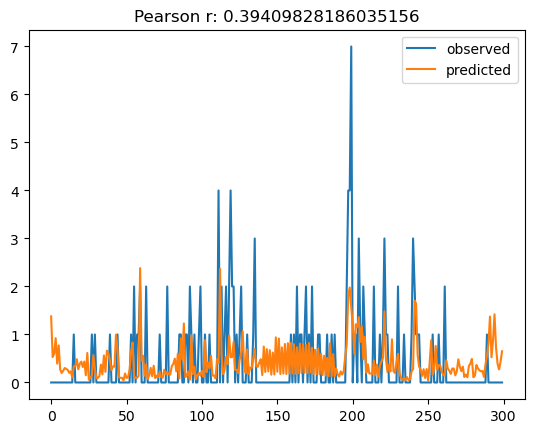

In [35]:
seq_num = 2444
plt.title(f"Pearson r: {pearsons[seq_num]}")
plt.plot(y_clip[seq_num].detach().numpy(), label="observed")
plt.plot(expected_counts[seq_num].detach().numpy(), label="predicted")
plt.legend()